## Channel Estimation

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn.metrics import mean_absolute_error, mean_squared_error
import commpy as cp

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [57]:
def generate_channel_estimation_dataset(dataset_size, preamble_length, constellations, SNR):
    QAMModem = cp.modulation.QAMModem(constellations)
    
    # use the constellation object to modulate the data bits into complex numbers
    
    preamble_bits = []
    preamble_bits_convolved = [] 
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    least_squares_preambles = []
    least_squares_preambles_convolved = []
    
    for i in range(dataset_size):
       
        preambles = np.random.randint(0, 2, preamble_length)
        preamble_bits.append(preambles)
        
        
        preambles_constellation =  QAMModem.modulate(preambles)
        least_squares_preambles.append(preambles_constellation)

        
        real_preambles = np.real(preambles_constellation)
        im_preambles = np.imag(preambles_constellation)
        real_im_preambles = np.vstack((real_preambles,im_preambles)).reshape((-1,),order='F')
        preambles_constellations.append(real_im_preambles)
        channel_taps = [0, 0]
        channel_taps[0] = np.random.uniform(-1, 1)
        channel_taps[1] = np.random.uniform(-1, 1)
        channel_taps = channel_taps / np.linalg.norm(channel_taps)
        channels.append(channel_taps)
        preamble_bits_convolved.append(sig.convolve(preambles, channel_taps, mode='same'))
        
        
        preamble_conv = add_awgn_noise(sig.convolve(preambles_constellation, channel_taps, mode='same'), SNR)
        least_squares_preambles_convolved.append(preamble_conv)
        
        real_preambles_conv = np.real(preamble_conv)
        im_preambles_conv = np.imag(preamble_conv)
        real_im_preambles_conv = np.vstack((real_preambles_conv,im_preambles_conv)).reshape((-1,),order='F')
        convolved_preambles.append(real_im_preambles_conv)
        
        
    X1 = np.hstack([preambles_constellations, np.array(convolved_preambles)])
    channels = np.array(channels)
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X1, channels, np.array(least_squares_preambles, dtype='complex'), np.array(least_squares_preambles_convolved, dtype='complex')

In [62]:
def create_model(input_layer_dim, hidden_layer_dim, input_dim, output_dim):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(hidden_layer_dim, activation='sigmoid'))
    model.add(Dense(output_dim, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [105]:
dataset_size = 50000
preamble_length = 100
QAM_scheme = 4
preamble_data, channels, lstsq_preambles, lstsq_preamble_convolved = generate_channel_estimation_dataset(dataset_size, preamble_length, QAM_scheme)
train_size = int(preamble_data.shape[0] * 0.8)
preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
channel_train, channel_test = channels[:train_size], channels[train_size:]
lstsq_preambles_test, lstsq_preambles_convolved_test = lstsq_preambles[train_size:], lstsq_preamble_convolved[train_size:]
# print(preamble_train.shape, preamble_test.shape)
# print(channel_train.shape, channel_test.shape)
# print(preamble_test, channel_test)


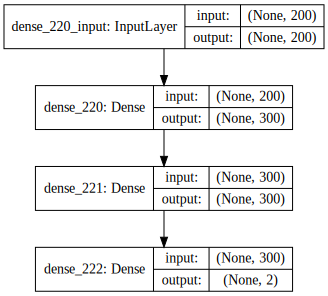

In [103]:
model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [104]:
def generate_topleitz(row_vector, channel_length):
    from scipy import linalg as la
    first_row = row_vector[:channel_length]
    first_col = row_vector
    return la.toeplitz(first_col, first_row)

def least_squares(A, b):
    return np.linalg.lstsq(A, b)[0]

def perform_least_squares(preamble, preamble_convolved, channel_length):
    A, b = generate_topleitz(preamble, channel_length), preamble_convolved
    prediction = least_squares(A, b)
    return np.array(prediction)

def run_least_squares_channel_est(preambles, preambles_convolved, channels):
    errors = []
    for preamble, preamble_convolved, channel in zip(preambles, preambles_convolved, channels):
        channel_estimate = np.real(perform_least_squares(preamble, preamble_convolved, channels.shape[1]))
        errors.append(mean_squared_error(channel, channel_estimate))
    return np.mean(np.array(errors))
        

error_lst_squares = run_least_squares_channel_est(lstsq_preambles, lstsq_preamble_convolved, channels)
print(error_lst_squares)
# print(predictions_least_squares)
# print(channel_test)
# mse = mean_squared_error(predictions_least_squares, channel_test)
# mabse = mean_absolute_error(predictions_least_squares, channel_test)
# print('Mean Squared Error: {0}'.format(mse))
# print('Mean Absolute Error: {0}'.format(mabse))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0.00015076780306240052


In [108]:
def run_channel_estimation_experiment():
    preamble_lengths = range(20, 201, 20)
    errors = []
    lstsq_errors = []
    knn_errors = []
    for preamble_length in preamble_lengths:
        print('Preamble length:', preamble_length)
        preamble_data, channels, lstsq_preambles, lstsq_preamble_convolved = generate_channel_estimation_dataset(50000, preamble_length, 4)
        print('Generated data')
        train_size = int(preamble_data.shape[0] * 0.8)
        preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
        channel_train, channel_test = channels[:train_size], channels[train_size:]
        lstsq_preambles_test, lstsq_preambles_convolved_test = lstsq_preambles[train_size:], lstsq_preamble_convolved[train_size:]
        model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
        history = model.fit(preamble_train, channel_train, validation_data=(preamble_test, channel_test), epochs=100, batch_size=64, verbose=0)
        error = history.history['val_loss'][-1]
        errors.append(error)
        print('Error NN:', error)
        
        error_lst_squares = run_least_squares_channel_est(lstsq_preambles_test, lstsq_preambles_convolved_test, channel_test)
        print('Error LSTSQ:', error_lst_squares)
        lstsq_errors.append(error_lst_squares)
        
        from sklearn.neighbors import KNeighborsRegressor
        neigh = KNeighborsRegressor(n_neighbors=15)
        neigh.fit(preamble_train, channel_train)
        knn_predictions = neigh.fit(preamble_test)
        error_knn = mean_squared_error(knn_predictions, channel_test)
        print('Error knn', error_knn)
        knn_errors.append(error_knn)
        
    return preamble_lengths, errors, lstsq_errors, knn_errors

preamble_lengths, errors, lstsq_errors, knn_errors = run_channel_estimation_experiment()

Preamble length: 20
Generated data
Error NN: 4.754407906439155e-05


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Error LSTSQ: 3.3957018369530616e+25
Preamble length: 40
Generated data
Error NN: 0.004040335788577795
Error LSTSQ: 0.000941029412518733
Preamble length: 60
Generated data
Error NN: 0.004707991209626197
Error LSTSQ: 0.00042014736153357814
Preamble length: 80
Generated data
Error NN: 0.009021696710586547
Error LSTSQ: 0.00023331364400975817
Preamble length: 100
Generated data
Error NN: 0.013438218662142754
Error LSTSQ: 0.00014950728863363872
Preamble length: 120
Generated data
Error NN: 0.017218790954351425
Error LSTSQ: 0.00010475193447906265
Preamble length: 140
Generated data
Error NN: 0.016708977895975113
Error LSTSQ: 7.696480009499078e-05
Preamble length: 160
Generated data
Error NN: 0.020766299739480017
Error LSTSQ: 5.82460430679427e-05
Preamble length: 180
Generated data
Error NN: 0.022629045289754866
Error LSTSQ: 4.650191001231202e-05
Preamble length: 200
Generated data
Error NN: 0.026092957919836044
Error LSTSQ: 3.7764953412524425e-05


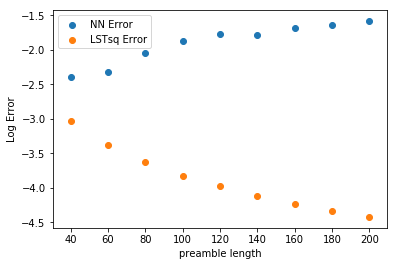

In [115]:
preamble_lengths = list(range(40, 201, 20))
plt.scatter(preamble_lengths, np.log10(errors[1:]), label='NN Error')
plt.scatter(preamble_lengths, np.log10(lstsq_errors[1:]), label='LSTsq Error')
plt.xlabel('preamble length')
plt.ylabel('Log Error')
plt.legend()
plt.show()

## One Tap Channel Inversion (Division)

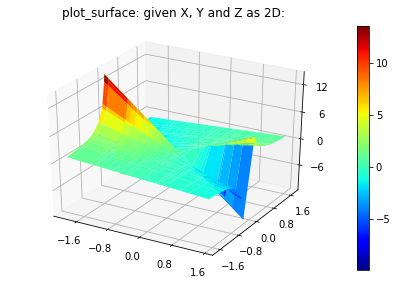

In [122]:
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn, shuffle
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape


# =========================
## generating ordered data:

N = 32
x = sorted(randn(N))
y = sorted(randn(N))

X, Y = meshgrid(x, y)
Z = X / Y


# ======================================
## reference picture (X, Y and Z in 2D):

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

title = ax.set_title("plot_surface: given X, Y and Z as 2D:")
title.set_y(1.01)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()
plt.savefig('Division_Function_plot.png', bbox_inches='tight')

In [70]:
def create_channel_inverse_model():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

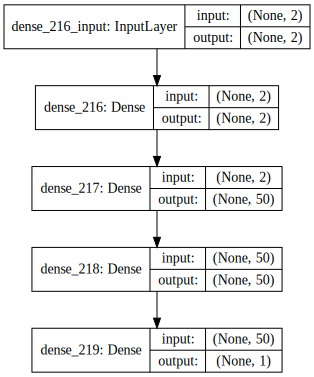

In [102]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
model_inverse = create_channel_inverse_model()
SVG(model_to_dot(model_inverse, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [76]:
def generate_one_tap_channel_inversion_data(dataset_size, channel_lower_bound):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(-1, 1)
        channel = np.random.uniform(channel_lower_bound, 1)
        data_X.append([data, channel])
        Y.append(data / channel)

    X, Y = np.array(data_X), np.array(Y)
    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test



In [77]:
def run_varying_channel_lower_bound_experiment():
    lower_bounds = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    errors = []
    for channel_lower_bound in lower_bounds:
        avg_error = []
        print(channel_lower_bound)
        for trial in range(5):
            print(trial)
            X_train, Y_train, X_test, Y_test = generate_one_tap_channel_inversion_data(10000, channel_lower_bound)
            model_inverse = create_channel_inverse_model()
            history = model_inverse.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=0)
            error = history.history['val_loss'][-1]
            avg_error.append(error)
        errors.append(sum(avg_error) / 5)
    return lower_bounds, errors


lower_bounds, errors = run_varying_channel_lower_bound_experiment()        
print(lower_bounds)
print(errors)

0
0
1
2
3
4
0.01
0
1
2
3
4
0.05
0
1
2
3
4
0.1
0
1
2
3
4
0.2
0
1
2
3
4
0.3
0
1
2
3
4
0.4
0
1
2
3
4
0.5
0
1
2
3
4
[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[4220.708897505438, 1.2571276032953524, 0.0029150321228429673, 0.00042879482945427304, 6.490642346034293e-05, 4.962954599759541e-05, 6.527368150418625e-05, 0.00029157309302827345]


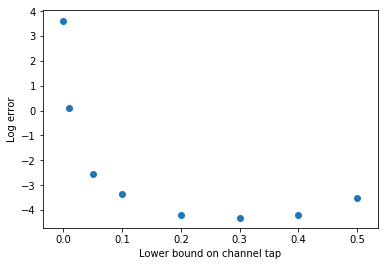

In [79]:
plt.scatter(lower_bounds, np.log10(errors))
plt.xlabel('Lower bound on channel tap')
plt.ylabel('Log error')
plt.show()

In [79]:
def create_channel_inverse_model():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

def generate_channel_inversion_one_tap_log_features(dataset_size, channel_lower_bound):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(0.1, 1)
        channel = np.random.uniform(channel_lower_bound, 1)
        data_X.append([data, channel])
        Y.append(data / channel)

    X, Y = np.log(np.array(data_X)), np.log(np.array(Y))

    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test

def run_varying_channel_lower_bound_experiment_log_features():
    lower_bounds = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    errors = []
    for channel_lower_bound in lower_bounds:
        avg_error = []
        print(channel_lower_bound)
        for trial in range(5):
            print(trial)
            X_train, Y_train, X_test, Y_test = generate_channel_inversion_one_tap_log_features(10000, channel_lower_bound)
            model_inverse = create_channel_inverse_model_log()
            history = model_inverse.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=0)
            error = history.history['val_loss'][-1]
            print('Error: {0}'.format(error))
            avg_error.append(error)
        errors.append(sum(avg_error) / 5)
    return lower_bounds, errors

lower_bounds, errors = run_varying_channel_lower_bound_experiment_log_features()  

0
0
Error: 4.957385820207258e-14
1
Error: 1.5276960930012475e-14
2
Error: 8.537100995749392e-14
3
Error: 3.229858010308817e-05
4
Error: 1.9588047412980815e-05
0.01
0
Error: 1.5806054002535236e-14
1
Error: 5.686233817137065e-12
2
Error: 3.1305491011990317e-13
3
Error: 1.4746391524544932e-11
4
Error: 6.314194186415989e-06
0.05
0
Error: 1.1757015771097362e-14
1
Error: 7.187668760177956e-11
2
Error: 6.913555557035155e-14
3
Error: 5.089352110854151e-10
4
Error: 1.8558657860490157e-11
0.1
0
Error: 1.1154165330089227e-13
1
Error: 2.506014559912728e-06
2
Error: 3.5123717961882404e-12
3
Error: 1.057217711775138e-08
4
Error: 9.312002368202024e-15
0.2
0
Error: 2.6473193700127933e-14
1
Error: 9.368030873604938e-15
2
Error: 1.2097627825717606e-13
3
Error: 4.964588344869015e-10
4
Error: 1.3766903972367573e-09
0.3
0
Error: 0.00012961585097946227
1
Error: 5.310332184291048e-15
2
Error: 9.536901256979036e-08
3
Error: 2.567167885717936e-05
4
Error: 1.1365786214750581e-14
0.4
0
Error: 8.655903142688882e-

<IPython.core.display.Javascript object>


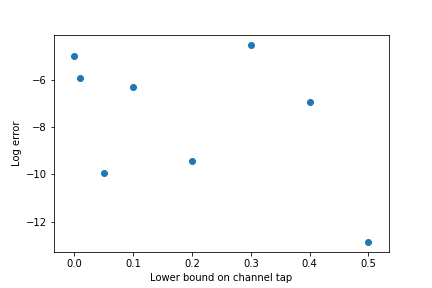

In [89]:
plt.scatter(lower_bounds, np.log10(errors))
plt.xlabel('Lower bound on channel tap')
plt.ylabel('Log error')
plt.show()

## Network for Multiplication

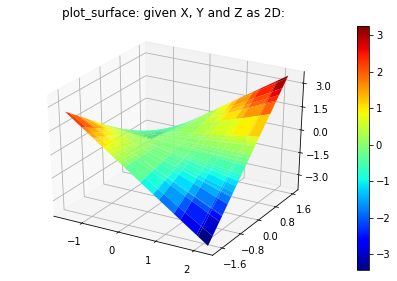

In [116]:
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn, shuffle
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape


# =========================
## generating ordered data:

N = 32
x = sorted(randn(N))
y = sorted(randn(N))

X, Y = meshgrid(x, y)
Z = X * Y


# ======================================
## reference picture (X, Y and Z in 2D):

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

title = ax.set_title("plot_surface: given X, Y and Z as 2D:")
title.set_y(1.01)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()
plt.savefig('Multiplication_Function_plot.png', bbox_inches='tight')


In [133]:
def generate_data_for_multiplication(dataset_size, upper_bound):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(-1, 1)
        channel = np.random.uniform(upper_bound)
        data_X.append([data, channel])
        Y.append(data * channel)

    X, Y = np.array(data_X), np.array(Y)
    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test

In [134]:
def create_channel_multiplication_model():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

In [135]:
from keras.utils import Sequence
class MultiplicationDataGenerator(Sequence):

    def __init__(self, batch_size, upper_bound):
        self.batch_size = batch_size
        self.x, self.y, _, _ = generate_data_for_multiplication(self.batch_size, upper_bound)
        self.epoch = 0
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y

    def on_epoch_end(self):
        self.x, self.y, _, _ = generate_data_for_multiplication(self.batch_size, upper_bound)
        self.epoch += 1

In [136]:
dataset_size = 50000
train_size = int(0.8 * dataset_size)
upper_bound = 10
mul_X_train, mul_Y_train, mul_X_test, mul_Y_test = generate_data_for_multiplication(dataset_size, upper_bound)
model_mul = create_channel_multiplication_model()

In [ ]:
batch_size = 1024
mul_data_generator = MultiplicationDataGenerator(batch_size, upper_bound)
history_mul = model_mul.fit_generator(mul_data_generator, steps_per_epoch=train_size // batch_size, validation_data=(mul_X_test, mul_Y_test), epochs=400)

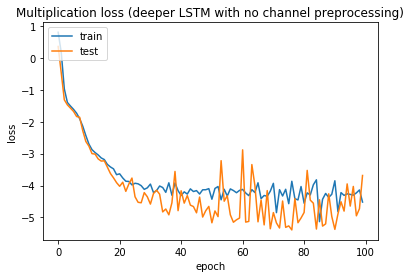

In [92]:
%matplotlib inline
plt.plot(np.log10(history_mul.history['val_loss']))
plt.title('Neural Network Muliplication Loss vs Epoch')
plt.ylabel('Log loss')
plt.xlabel('epoch')
plt.legend(['test data'], loc='upper right')
# plt.xscale('log')
plt.savefig('/content/gdrive/My Drive/Multiplication_loss_vs_epoch.png', bbox_inches='tight')
plt.show()

In [ ]:
def run_varying_channel_upper_bound_experiment():
    upper_bounds = [1, 5, 10, 20, 50, 100, 500]
    errors = []
    for channel_upper_bound in upper_bounds:
        avg_error = []
        print('Upper bound', channel_upper_bound)
        for trial in range(2):
            print('Trial', trial)
            X_train, Y_train, X_test, Y_test = generate_data_for_multiplication(50000, channel_upper_bound)
            batch_size = 1024
            train_size = 10240
            mul_data_generator = MultiplicationDataGenerator(batch_size, channel_upper_bound)
            history_mul = model_mul.fit_generator(mul_data_generator, steps_per_epoch=train_size // batch_size, validation_data=(X_test, Y_test), epochs=100, verbose=0)
            error = history_mul.history['val_loss'][-1]
            print('Error', error)
            avg_error.append(error)
        errors.append(sum(avg_error) / 2)
    return upper_bounds, errors

In [ ]:
upper_bounds, errors = run_varying_channel_upper_bound_experiment()

In [ ]:
# This will generate the loss vs upper bound plot
plt.scatter(upper_bounds, np.log10(errors))
plt.xlabel('Upper bound on channel')
plt.ylabel('Log loss')
plt.title('Loss of multiplication network as upper bound on channel increases')
plt.savefig('/content/gdrive/My Drive/Channel_upper_bound_multiplication.png', bbox_inches='tight')
plt.show()

In [95]:
def generate_data_for_multiplication_log(dataset_size):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(0.2, 1)
        channel = np.random.uniform(10)
        data_X.append([data, channel])
        Y.append(data * channel)

    X, Y = np.log10(np.array(data_X)), np.log10(np.array(Y))
    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test

def create_channel_multiplication_model_log():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='linear'))
    model_inverse.add(Dense(50, activation='linear'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

In [96]:
dataset_size = 50000
mul_X_train_log, mul_Y_train_log, mul_X_test_log, mul_Y_test_log = generate_data_for_multiplication_log(dataset_size)
model_mul = create_channel_multiplication_model_log()
history_log = model_mul.fit(mul_X_train_log, mul_Y_train_log, validation_data=(mul_X_test_log, mul_Y_test_log), epochs=100, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.1528e-15 - val_mean_squared_error: 3.1528e-15
Epoch 2/100
40000/40000 [==============================] - 1s - loss: 3.2815e-15 - mean_squared_error: 3.2815e-15 - val_loss: 3.1452e-15 - val_mean_squared_error: 3.1452e-15
Epoch 3/100
40000/40000 [==============================] - 1s - loss: 3.3406e-15 - mean_squared_error: 3.3406e-15 - val_loss: 3.1004e-15 - val_mean_squared_error: 3.1004e-15
Epoch 4/100
40000/40000 [==============================] - 1s - loss: 3.4119e-15 - mean_squared_error: 3.4119e-15 - val_loss: 5.1045e-15 - val_mean_squared_error: 5.1045e-15
Epoch 5/100
40000/40000 [==============================] - 2s - loss: 4.0357e-15 - mean_squared_error: 4.0357e-15 - val_loss: 3.3508e-15 - val_mean_squared_error: 3.3508e-15
Epoch 6/100
40000/40000 [==============================] - 1s - loss: 4.2896e-05 - mean_

40000/40000 [==============================] - 2s - loss: 9.1855e-07 - mean_squared_error: 9.1855e-07 - val_loss: 2.3485e-15 - val_mean_squared_error: 2.3485e-15
Epoch 94/100
40000/40000 [==============================] - 2s - loss: 2.5537e-09 - mean_squared_error: 2.5537e-09 - val_loss: 4.7039e-07 - val_mean_squared_error: 4.7039e-07
Epoch 95/100
40000/40000 [==============================] - 2s - loss: 6.2186e-07 - mean_squared_error: 6.2186e-07 - val_loss: 1.5186e-12 - val_mean_squared_error: 1.5186e-12
Epoch 96/100
40000/40000 [==============================] - 1s - loss: 4.8432e-07 - mean_squared_error: 4.8432e-07 - val_loss: 1.4900e-13 - val_mean_squared_error: 1.4900e-13
Epoch 97/100
40000/40000 [==============================] - 1s - loss: 2.5483e-07 - mean_squared_error: 2.5483e-07 - val_loss: 1.7054e-11 - val_mean_squared_error: 1.7054e-11
Epoch 98/100
40000/40000 [==============================] - 2s - loss: 1.3202e-06 - mean_squared_error: 1.3202e-06 - val_loss: 1.9216e-15 

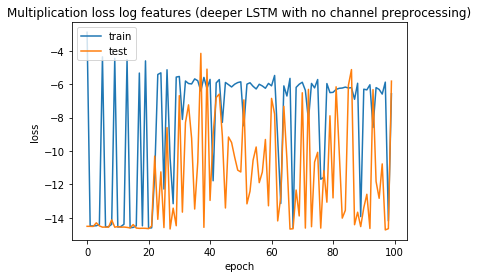

In [97]:
%matplotlib inline
plt.plot(np.log10(history_log.history['loss']))
plt.plot(np.log10(history_log.history['val_loss']))
plt.title('Multiplication loss log features (deeper LSTM with no channel preprocessing)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Equalization

In [4]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector

In [5]:
def qam_4_modulation(bitstring):
    modulated_symbol = []
    reshaped_bit_string = bitstring.reshape((len(bitstring) // 2 , 2))

    for row in reshaped_bit_string:
        if np.array_equal(row, np.array([0, 0])):
            modulated_symbol.append(1 + 1j)
        elif np.array_equal(row, np.array([1, 0])):
            modulated_symbol.append(-1 + 1j)
        elif np.array_equal(row, np.array([1, 1])):
            modulated_symbol.append(-1 - 1j)
        else:
            modulated_symbol.append(1 - 1j)
    return np.array(modulated_symbol)

def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/20.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    
    return y.flatten()

In [50]:
def generate_combined_dataset_qam_4_edited(dataset_size,  preamble_length, data_length, channel_length, SNR, constellations):
#     QAMModem = cp.modulation.QAMModem(constellations)
    
    # use the constellation object to modulate the data bits into complex numbers
    
    
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    
    for i in range(dataset_size):
        input_data_bits = np.random.randint(0, 2, data_length)
        preambles = np.random.randint(0, 2, preamble_length)
        
        input_data_constellation = qam_4_modulation(input_data_bits)
        real_input = np.real(input_data_constellation)
        im_input = np.imag(input_data_constellation)
        real_im_input = np.vstack((real_input,im_input)).T
        input_data_constellations.append(real_im_input)
        
        preambles_constellation =  qam_4_modulation(preambles)
        real_preambles = np.real(preambles_constellation)
        im_preambles = np.imag(preambles_constellation)
        real_im_preambles = np.vstack((real_preambles,im_preambles)).reshape((-1,),order='F')
        preambles_constellations.append(real_im_preambles)
        channel_taps = [0, 0]
        channel_taps[0] = np.random.uniform(-1, 1)
        channel_taps[1] = np.random.uniform(-1, 1)
        channel_taps = channel_taps / np.linalg.norm(channel_taps)
        channels.append(channel_taps)
        
        preamble_conv = sig.convolve(preambles_constellation, channel_taps, mode='same')
        real_preambles_conv = np.real(preamble_conv)
        im_preambles_conv = np.imag(preamble_conv)
        real_im_preambles_conv = np.vstack((real_preambles_conv,im_preambles_conv)).reshape((-1,),order='F')
        convolved_preambles.append(real_im_preambles_conv)
        
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellation, channel_taps, mode='same'), SNR)
        real_constellation_conv = np.real(constellation_convolved)
        im_constellation_conv = np.imag(constellation_convolved)
        real_im_constellation_conv = np.vstack((real_constellation_conv,im_constellation_conv)).T
        convolved_data_constellations.append(real_im_constellation_conv)
        
    X1 = np.hstack([preambles_constellations, np.array(convolved_preambles)])
    X2 = np.array(convolved_data_constellations)
    Y = np.array(input_data_constellations)
    channels = np.array(channels)
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X1, X2, Y, channels

In [51]:
def transform_data(channel_data, convolved_data, input_data_symbols, sequence_length, window_length=3):
    channels, convolved_data_features, input_data_symbols_target = [], [], []
    for i in range(convolved_data.shape[0]):
        data_sequence, input_symbols = convolved_data[i], input_data_symbols[i]
        channel = channel_data[i]
        for j in range(sequence_length - window_length + 1):
            convolved_data_features.append(data_sequence[j:j+window_length])
            input_data_symbols_target.append(input_symbols[j:j+window_length])
            channels.append(channel)
    #       print(i, j)
          
    return np.array(channels), np.array(convolved_data_features), np.array(input_data_symbols_target)

In [96]:
def generate_training_data_equalization(dataset_size, preamble_length, data_length, channel_length, SNR, constellations, window_length):
    preamble_data, convolved_data, input_data_symbols, channels = generate_combined_dataset_qam_4_edited(dataset_size, preamble_length, data_length, channel_length, SNR, constellations)
    channels, convolved_data, input_data_symbols = transform_data(channels, convolved_data, input_data_symbols, data_length // 2, window_length)
    
    preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
    convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
    input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
    channel_train, channel_test = channels[:train_size], channels[train_size:]
    return [channel_train, convolved_train], input_data_symbols_train

from keras.utils import Sequence

class DataGenerator(Sequence):

    def __init__(self, dataset_size, preamble_length, data_length, channel_length, 
                 SNR, constellations, window_length, batch_size):
        self.x, self.y = generate_training_data_equalization(dataset_size, preamble_length, data_length, channel_length, 
                 SNR, constellations, window_length)
        self.epoch = 0
        self.batch_size = batch_size
        self.dataset_size = dataset_size
        self.preamble_length = preamble_length
        self.data_length = data_length
        self.channel_length = channel_length
        self.SNR = SNR
        self.constellations = constellations
        self.window_length = window_length

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = [self.x[0][idx * self.batch_size:(idx + 1) * self.batch_size], 
                   self.x[1][idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         print(batch_x)
#         print(batch_y)
        return batch_x, batch_y

    def on_epoch_end(self):
#         print('Generating data')
        self.x, self.y = generate_training_data_equalization(self.batch_size, self.preamble_length, self.data_length, 
                                                             self.channel_length, self.SNR, self.constellations, self.window_length)
            # modify data
        self.epoch += 1
        
        


In [109]:
preamble_length = 80
data_length = 60
dataset_size = 50000
channel_length = 2
SNR = 100
constellations = 4
window_length = 10
batch_size = 1024
preamble_data, convolved_data, input_data_symbols, channels = generate_combined_dataset_qam_4_edited(dataset_size, preamble_length, data_length, channel_length, SNR, constellations)
channels, convolved_data, input_data_symbols = transform_data(channels, convolved_data, input_data_symbols, data_length // 2, window_length=window_length)
train_size = int(input_data_symbols.shape[0] * 0.8)
preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
channel_train, channel_test = channels[:train_size], channels[train_size:]
# print(preamble_train.shape, preamble_test.shape)
print(convolved_train.shape, convolved_test.shape)
print(input_data_symbols_train.shape, input_data_symbols_test.shape)
print(channel_train.shape, channel_test.shape)

(840000, 10, 2) (210000, 10, 2)
(840000, 10, 2) (210000, 10, 2)
(840000, 2) (210000, 2)


In [98]:
data_generator = DataGenerator(dataset_size, preamble_length, data_length, channel_length, 
                 SNR, constellations, window_length, batch_size)
data_generator

In [99]:
def build_end_to_end_model_two_tap_channel_deeper_LSTM_no_preprocessing(preamble_length, data_length, channel_length, output_length):
    
    channel = Input(shape=(channel_length,))
    data = Input(shape=(data_length, 2))
    channel_repeated = RepeatVector(data_length)(channel)

    output = concatenate([data, channel_repeated])
    data_layers = Bidirectional(LSTM(90, return_sequences=True))(output)
    data_layers_2 = Bidirectional(LSTM(90, return_sequences=True))(data_layers)
    data_layers_3 = Bidirectional(LSTM(90, return_sequences=True))(data_layers_2)
    data_layers_4 = Bidirectional(LSTM(90, return_sequences=True))(data_layers_3)

    output_1 = TimeDistributed(Dense(100, activation='relu'))(data_layers_4)
    output_2 = TimeDistributed(Dense(100, activation='relu'))(output_1)
    output = TimeDistributed(Dense(2, activation='linear'))(output_1)
    model = Model(inputs=[channel, data], outputs=[output])

    model.compile(optimizer='adagrad', loss='mse', metrics=['mse'])
    return model

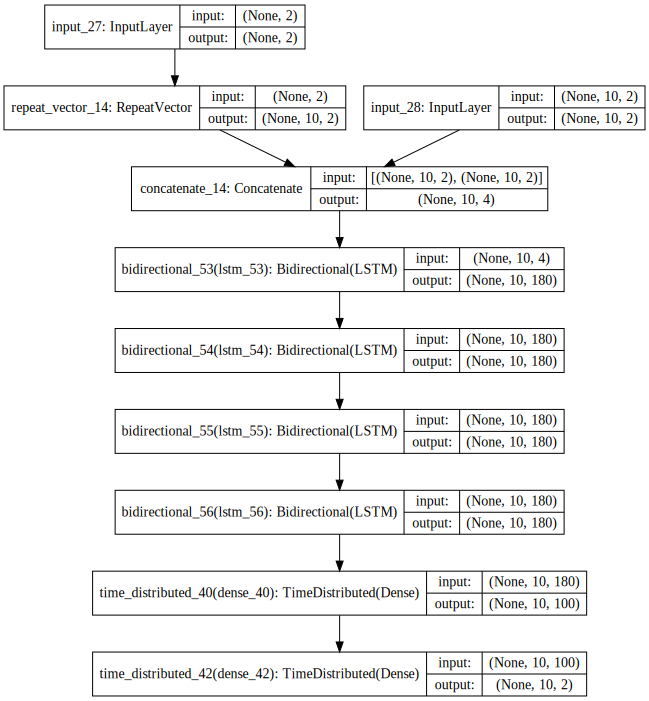

In [100]:
model4 = build_end_to_end_model_two_tap_channel_deeper_LSTM_no_preprocessing(channel_train.shape[1], convolved_train.shape[1], channel_length, input_data_symbols_train.shape[1])
SVG(model_to_dot(model4, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [101]:
history_model4 = model4.fit_generator(data_generator, steps_per_epoch=train_size // batch_size, validation_data=([channel_test, convolved_test], [input_data_symbols_test]), epochs=200)

Epoch 1/200
82/82 [==============================] - 223s - loss: 0.7945 - mean_squared_error: 0.7945 - val_loss: 0.6419 - val_mean_squared_error: 0.6419
Epoch 2/200
82/82 [==============================] - 218s - loss: 0.2279 - mean_squared_error: 0.2279 - val_loss: 0.0980 - val_mean_squared_error: 0.0980
Epoch 3/200
82/82 [==============================] - 210s - loss: 0.0858 - mean_squared_error: 0.0858 - val_loss: 0.0684 - val_mean_squared_error: 0.0684
Epoch 4/200
82/82 [==============================] - 200s - loss: 0.0614 - mean_squared_error: 0.0614 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 5/200
82/82 [==============================] - 200s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 6/200
82/82 [==============================] - 201s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 7/200
82/82 [==============================] - 201s - loss: 0.0381 - m

82/82 [==============================] - 215s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 54/200
82/82 [==============================] - 205s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 55/200
82/82 [==============================] - 214s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 56/200
82/82 [==============================] - 226s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 57/200
82/82 [==============================] - 215s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 58/200
82/82 [==============================] - 210s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 59/200
82/82 [==============================] - 217s - loss: 0.0031 - mean_sq

82/82 [==============================] - 201s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 106/200
82/82 [==============================] - 201s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 107/200
82/82 [==============================] - 200s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 108/200
82/82 [==============================] - 201s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 109/200
82/82 [==============================] - 201s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 110/200
82/82 [==============================] - 200s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 111/200
82/82 [==============================] - 201s - loss: 0.0021 - m

82/82 [==============================] - 201s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 158/200
82/82 [==============================] - 200s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 159/200
82/82 [==============================] - 200s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 160/200
82/82 [==============================] - 201s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 161/200
82/82 [==============================] - 201s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 162/200
82/82 [==============================] - 200s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 163/200
82/82 [==============================] - 201s - loss: 0.0014 - m

KeyboardInterrupt: 

NameError: name 'history_model4s' is not defined

In [110]:
predictions4 = model4.predict([channel_test, convolved_test])

In [111]:
def calc_accuracy(original, predictions):
    return np.sum(original == predictions) / (original.shape[0] * original.shape[1])


In [112]:
rounded_predictions4 = np.where(predictions4 > 0, 1, -1)
print(channel_test)
print(rounded_predictions4.shape)
# print(rounded_predictions4.shape, input_data_symbols_test.shape)
new_shape = (rounded_predictions4.shape[0] * rounded_predictions4.shape[1], 2)
rounded_predictions_reshaped4 = rounded_predictions4.reshape(new_shape)
test_data_reshaped4 = input_data_symbols_test.reshape(new_shape)
calc_accuracy(rounded_predictions_reshaped4, test_data_reshaped4)

[[-0.89329724  0.44946639]
 [-0.89329724  0.44946639]
 [-0.89329724  0.44946639]
 ...
 [ 0.6832927  -0.73014456]
 [ 0.6832927  -0.73014456]
 [ 0.6832927  -0.73014456]]
(210000, 10, 2)


0.9993792857142857

In [113]:
error_channels = []
for i in range(rounded_predictions4.shape[0]):
    for j in range(3):
        if not np.array_equal(rounded_predictions4[i][j], input_data_symbols_test[i][j]):
            print('Channel', channel_test[i])
            print('Prediction', predictions4[i][j])
            print('QPSK Prediction', rounded_predictions4[i][j])
            print('True QPSK', input_data_symbols_test[i][j])
            error_channels.append(channel_test[i])

Channel [-0.71913158 -0.69487393]
Prediction [ 0.9566444  -0.05529559]
QPSK Prediction [ 1 -1]
True QPSK [1. 1.]
Channel [-0.71913158 -0.69487393]
Prediction [1.0279237  0.20912854]
QPSK Prediction [1 1]
True QPSK [ 1. -1.]
Channel [-0.71913158 -0.69487393]
Prediction [ 1.0361636  -0.08044451]
QPSK Prediction [ 1 -1]
True QPSK [1. 1.]
Channel [-0.71913158 -0.69487393]
Prediction [1.015902   0.10770337]
QPSK Prediction [1 1]
True QPSK [ 1. -1.]
Channel [-0.71913158 -0.69487393]
Prediction [ 1.0314447  -0.12052026]
QPSK Prediction [ 1 -1]
True QPSK [1. 1.]
Channel [-0.71913158 -0.69487393]
Prediction [-1.04097    0.4686173]
QPSK Prediction [-1  1]
True QPSK [-1. -1.]
Channel [-0.72673827 -0.68691447]
Prediction [ 0.94050574 -0.05166346]
QPSK Prediction [ 1 -1]
True QPSK [1. 1.]
Channel [0.70114398 0.71301971]
Prediction [ 0.7482526  -0.16552939]
QPSK Prediction [ 1 -1]
True QPSK [1. 1.]
Channel [0.70114398 0.71301971]
Prediction [-0.8977239   0.06457253]
QPSK Prediction [-1  1]
True QPSK

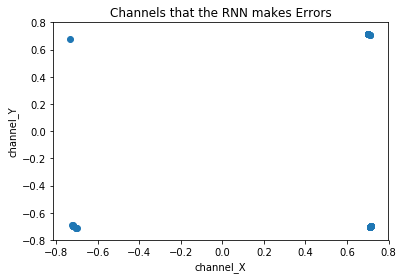

In [129]:
## This plots which channels the RNN makes errors on
channel_errors = np.array(error_channels)
plt.title('Channels that the RNN makes Errors')
plt.xlabel('channel_X')
plt.ylabel('channel_Y')
plt.scatter(channel_errors[:, 0], channel_errors[:, 1])
plt.savefig('Incorrect channels', bbox_inches='tight')
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error
statistics_count = {(np.sqrt(2) / 2, np.sqrt(2) / 2): 0, (-np.sqrt(2) / 2, np.sqrt(2) / 2): 0, (np.sqrt(2) / 2, -np.sqrt(2) / 2): 0, (-np.sqrt(2) / 2, -np.sqrt(2) / 2): 0, (0, -1): 0}
statistics_errors = {(np.sqrt(2) / 2, np.sqrt(2) / 2): 0, (-np.sqrt(2) / 2, np.sqrt(2) / 2): 0, (np.sqrt(2) / 2, -np.sqrt(2) / 2): 0, (-np.sqrt(2) / 2, -np.sqrt(2) / 2): 0, (0, -1): 0}
good_channel_errors = []
bad_channel_errors = []
for i in range(rounded_predictions4.shape[0]):
    for j in range(3):
        if not np.array_equal(rounded_predictions4[i][j], input_data_symbols_test[i][j]):
            channel = channel_test[i]
            for key in statistics_count:
                if mean_squared_error(channel, np.array(key)) < 0.1:
                    statistics_count[key] += 1
                    error = mean_squared_error(predictions4[i][j], input_data_symbols_test[i][j])
                    statistics_errors[key] += error
#       print('Channel', channel_test[i])
#       print('Prediction', predictions4[i][j])
#       print('QPSK Prediction', rounded_predictions4[i][j])
#       print('True QPSK', input_data_symbols_test[i][j])
            bad_channel_errors.append(mean_squared_error(predictions4[i][j], input_data_symbols_test[i][j]))
    else:
        good_channel_errors.append(mean_squared_error(predictions4[i][j], input_data_symbols_test[i][j]))

for key in statistics_errors:
    if statistics_count[key] > 0:
        statistics_errors[key] = statistics_errors[key] / statistics_count[key]

In [127]:
print('Good channel error', sum(good_channel_errors) / len(good_channel_errors))
print('Bad channel error', sum(bad_channel_errors) / len(bad_channel_errors))
print('Total Bad Channels', len(bad_channel_errors))
statistics_count_rounded = {}
statistics_errors_rounded = {}
for key in statistics_count:
    rounded_key = (np.round(key[0], 3), np.round(key[1], 3))
    statistics_count_rounded[rounded_key] = statistics_count[key]
    statistics_errors_rounded[rounded_key] = statistics_errors[key]
print(statistics_count_rounded)
print(statistics_errors_rounded)


Good channel error 0.0002638874699068144
Bad channel error 0.7306372348726573
Total Bad Channels 43
{(0.707, 0.707): 14, (-0.707, 0.707): 1, (0.707, -0.707): 16, (-0.707, -0.707): 12, (0, -1): 0}
{(0.707, 0.707): 0.7162300079403883, (-0.707, 0.707): 0.5236157671769702, (0.707, -0.707): 0.8172570317294764, (-0.707, -0.707): 0.64920439279252, (0, -1): 0}


## MMSE Equalizer vs RNN Equalizer

In [151]:
def generate_topleitz(row_vector, channel_length):
    import scipy.linalg as la
    first_row = row_vector[:channel_length]
    first_col = row_vector
    return la.toeplitz(first_col, first_row)

def least_squares(A, b):
    return np.linalg.lstsq(A, b)[0]

def perform_least_squares(preamble, preamble_convolved, channel_length):
    A, b = generate_topleitz(preamble, channel_length), preamble_convolved
    prediction = least_squares(A, b)
    return np.array(prediction)

def generate_A_hat(channel_estimate, data_length):
    matrix = np.zeros((data_length, data_length), dtype='complex')
    for i in range(data_length - 1): 
        matrix[i][i] = channel_estimate[0]
        matrix[i+1][i] = channel_estimate[1]
    matrix[data_length - 1][data_length - 1] = channel_estimate[0]
    return matrix

# MMSE

def MMSE_equalization_QPSK_SVD(channel_estimate, data_convolved, data_length, snr):
    std = 10 ** (-snr / 20)
    A_hat = generate_A_hat(channel_estimate, data_length)

    A_hat = np.asmatrix(A_hat)
    to_invert = np.dot(A_hat, A_hat.H) + (std ** 2) * np.identity(data_length)
    eigenvalues, eigenvectors = np.linalg.eig(to_invert)
    eigenvalues_2, eigenvectors_2 = np.linalg.eig(np.dot(A_hat, A_hat.H))
    B = np.dot(np.linalg.pinv(to_invert), A_hat)
    data_est = np.dot(B.H, data_convolved)
    return data_est

def run_MMSE(convolved_data_full, channels, input_data_constellations, snr):
    errors_MMSE = []
    i = 0
    for convolved_data, channel, input_data_constellation in zip(convolved_data_full, channels, input_data_constellations):
#         print(i)
        convolved_data = tranform_2d_array_into_complex(convolved_data)
        input_data_constellation = tranform_2d_array_into_complex(input_data_constellation)
        lms_test_output = MMSE_equalization_QPSK_SVD(channel, convolved_data, input_data_constellation.shape[0], snr)
        lms_mse = mse_middle(lms_test_output, input_data_constellation, 10)
#         print(lms_mse)
        errors_MMSE.append(lms_mse)
        i += 1
    return np.mean(np.array(errors_MMSE))

def tranform_2d_array_into_complex(arr):
    new_array = np.zeros(arr.shape[0], dtype='complex')
    new_array.real = arr[:, 0]
    new_array.imag = arr[:, 1]
    return new_array
def mse_middle(predicted_signal, test_signal, index):
    predicted_signal = np.array(predicted_signal).flatten()
#     print(predicted_signal.shape)
    predicted_signal = predicted_signal[index:(len(test_signal) - index)]
    test_signal = test_signal[index:(len(test_signal) - index)]
#     print(predicted_signal.shape, test_signal.shape)
    from sklearn.metrics import mean_squared_error
    real_test_sig, real_predicted_sig = np.real(test_signal), np.real(predicted_signal)
    imag_test_sig, imag_predicted_sig = np.imag(test_signal), np.imag(predicted_signal)
    real_im_test = np.vstack((real_test_sig, imag_test_sig)).T
    real_im_predicted = np.vstack((real_predicted_sig, imag_predicted_sig)).T
    return mean_squared_error(real_im_test, real_im_predicted)

In [142]:
## MMSE Data generation
preamble_length = 80
data_length = 60
dataset_size = 50000
channel_length = 2
SNR = 100
constellations = 4
preamble_data, convolved_data, input_data_symbols, channels = generate_combined_dataset_qam_4_edited(dataset_size, preamble_length, data_length, channel_length, SNR, constellations)
train_size = int(input_data_symbols.shape[0] * 0.8)
preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
channel_train, channel_test = channels[:train_size], channels[train_size:]
print(preamble_train.shape, preamble_test.shape)
print(convolved_train.shape, convolved_test.shape)
print(input_data_symbols_train.shape, input_data_symbols_test.shape)
print(channel_train.shape, channel_test.shape)
print(channels)

(40000, 160) (10000, 160)
(40000, 30, 2) (10000, 30, 2)
(40000, 30, 2) (10000, 30, 2)
(40000, 2) (10000, 2)
[[ 0.18674749  0.98240795]
 [ 0.81052259 -0.58570738]
 [-0.49947786 -0.86632665]
 ...
 [ 0.98481808 -0.17358962]
 [-0.85390431 -0.52043004]
 [ 0.45812146  0.8888896 ]]


In [161]:
def compare_RNN_and_MMSE():
    SNRS = [1, 10, 50, 100, 500, 1000, 5000]
    errors_RNN = []
    errors_MMSE = []
    for SNR in SNRS:
        ## MMSE Data generation
        print('SNR', SNR)
        preamble_length = 80
        data_length = 60
        dataset_size = 50000
        channel_length = 2
        constellations = 4
        preamble_data, convolved_data, input_data_symbols, channels = generate_combined_dataset_qam_4_edited(dataset_size, preamble_length, data_length, channel_length, SNR, constellations)
        train_size = int(input_data_symbols.shape[0] * 0.8)
        preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
        convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
        input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
        channel_train, channel_test = channels[:train_size], channels[train_size:]
        print('Finished generating data for MMSE')
        error_MMSE = run_MMSE(convolved_test, channel_test, input_data_symbols_test, SNR)
        print('Error MMSE', error_MMSE)
        errors_MMSE.append(error_MMSE)
        
        # RNN Test Data Generation
        window_length = 10
        channels, convolved_data, input_data_symbols = transform_data(channels, convolved_data, input_data_symbols, data_length // 2, window_length=window_length)
        train_size = int(input_data_symbols.shape[0] * 0.8)
        preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
        convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
        input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
        channel_train, channel_test = channels[:train_size], channels[train_size:]
        print('Finished transforming data for RNN')
        predictions4 = model4.predict([channel_test, convolved_test])
        new_shape = (predictions4.shape[0] * predictions4.shape[1], 2)
        predictions4 = predictions4.reshape(new_shape)
        
        input_data_symbols_test = input_data_symbols_test.reshape(new_shape)
        error_RNN = mean_squared_error(predictions4, input_data_symbols_test)
        print('Error RNN', error_RNN)
        errors_RNN.append(error_RNN)
    return SNRS, errors_RNN, errors_MMSE


In [162]:
SNRS, errors_RNN, errors_MMSE = compare_RNN_and_MMSE()

SNR 1
Finished generating data for MMSE
Error MMSE 0.5165877097623547
Finished transforming data for RNN
Error RNN 0.640224685214764
SNR 10
Finished generating data for MMSE
Error MMSE 0.3565397769004156
Finished transforming data for RNN
Error RNN 0.29007638268959374
SNR 50
Finished generating data for MMSE
Error MMSE 0.03500069336586178
Finished transforming data for RNN
Error RNN 0.00488730360186191
SNR 100
Finished generating data for MMSE
Error MMSE 0.06333870376876896
Finished transforming data for RNN
Error RNN 0.001992637938601211
SNR 500
Finished generating data for MMSE
Error MMSE 2.4920730549456855e-08
Finished transforming data for RNN
Error RNN 0.002126244683376098
SNR 1000
Finished generating data for MMSE
Error MMSE 2.6760707908787254e-08
Finished transforming data for RNN
Error RNN 0.001893772753789164
SNR 5000
Finished generating data for MMSE
Error MMSE 2.242762227507016e-08
Finished transforming data for RNN
Error RNN 0.002181193583828374


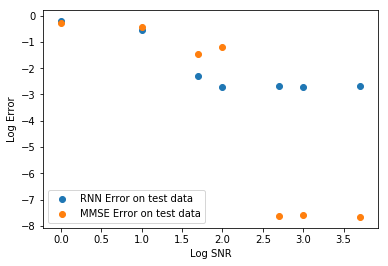

In [171]:
plt.scatter(np.log10(SNRS), np.log10(errors_RNN), label='RNN Error on test data')
plt.scatter(np.log10(SNRS), np.log10(errors_MMSE), label='MMSE Error on test data')
plt.xlabel('Log SNR')
plt.ylabel('Log Error')
plt.legend()
plt.savefig('RNN_vs_MMSE.png', bbox_inches='tight')

plt.show()